In [1]:
import acl
import numpy as np
from PIL import Image, ImageDraw
from acl_sample import Sample
import struct
from constant import NPY_BYTE, ACL_MEMCPY_DEVICE_TO_HOST, ACL_MEM_MALLOC_NORMAL_ONLY, ACL_MEMCPY_HOST_TO_DEVICE
from postprocessing import postprocess_boxes
import cv2
import matplotlib.pyplot as plt

In [90]:
device_id = 0
input_size = 416
model_path = "./model/yolov3_caffe.om"
img_dict = {"path": "./data/shot_cropped.jpg", "dtype": np.uint8}

In [91]:
sample = Sample(device_id,
                model_path,
                input_size,
                input_size)

[Sample] init resource stage:
[Sample] init resource stage success
[Model] class Model init resource stage:
结构 94711388555296
input number:2
input 1: 16
[Model] create model output dataset:
[Model] create model output dataset success
[Model] class Model init resource stage success


In [96]:
img_org_bgr.shape

(525, 719, 3)

In [113]:
img_org_bgr = cv2.imread(img_dict["path"])
img_resized = resize_image(img_org_bgr, (416, 416))

In [114]:
img_yuv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YUV_I420)

In [116]:
ptr = acl.util.numpy_to_ptr(img_yuv)

img_dev_ptr, ret = acl.rt.malloc(259584, ACL_MEM_MALLOC_NORMAL_ONLY )
print(ret)
ret = acl.rt.memcpy(img_dev_ptr, 259584, ptr, 259584, ACL_MEMCPY_HOST_TO_DEVICE)
print(ret)
model_output = sample.model_process.run(img_dev_ptr, 259584, 525, 719)

0
0
[Model] create model input dataset:
input2 [416. 416. 525. 719.], size:4
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success
result ouput 1
{'x1': 205.0, 'y1': 184.0, 'x2': 286.25, 'y2': 243.875, 'detection_scores': 0.9697265625, 'detection_classes': 32.0}
result [205.         184.         286.25       ...  -0.43432617   1.2285156
  -0.28930664]
[RESULT]  num_detections:  1
[RESULT]  result:  1
[RESULT]  detection_classes:  32.0
[RESULT]  detection_scores:  0.9697265625
[RESULT]  detection_boxes:  205.0 184.0 286.25 243.875
dataset {'num_detections': 1, 0: {'x1': 205.0, 'y1': 184.0, 'x2': 286.25, 'y2': 243.875, 'detection_scores': 0.9697265625, 'detection_classes': 32.0}}


In [117]:
def resize_image(img, size=(28,28)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else \
                    cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

In [79]:
# %timeit -n 100 -r 10
model_output = sample.forward(img_dict)

[Sample] width:768 height:576
[Sample] image:./data/dog.jpg
[Dvpp] vpc decode stage:
decode_out_buffer_size: 663552
temp_width:%d,temp_height:$d 768 576
[Dvpp] vpc decode stage success
[Dvpp] vpc resize stage:
decode_out_buffer_size: 663552
temp_width:%d,temp_height:$d 768 576
decode_out_buffer_size: 259584
temp_width:%d,temp_height:$d 416 416
[Dvpp] crop and paste roi config success
[Dvpp] vpc resize stage success
17729630502912 259584
[Model] create model input dataset:
input2 [416. 416. 576. 768.], size:4
[Model] create model input dataset success
[Model] execute stage:
[Model] execute stage success
result ouput 3
{'x1': 155.25, 'y1': 119.8125, 'x2': 567.0, 'y2': 440.0, 'detection_scores': 0.99609375, 'detection_classes': 1.0}
{'x1': 475.5, 'y1': 86.0625, 'x2': 689.0, 'y2': 170.75, 'detection_scores': 0.89404296875, 'detection_classes': 7.0}
{'x1': 127.5, 'y1': 226.125, 'x2': 315.5, 'y2': 535.0, 'detection_scores': 0.98828125, 'detection_classes': 16.0}
result [ 1.5525000e+02  4.755

In [118]:
acl.mdl.get_dataset_num_buffers(model_output)

2

In [119]:
def get_model_output_by_index(model_output, i, num_classes = 80):
    temp_output_buf = acl.mdl.get_dataset_buffer(model_output, i)

    infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
    infer_output_size = acl.get_data_buffer_size(temp_output_buf)
    print("infer_output_size", infer_output_size)
    
    output_host, _ = acl.rt.malloc_host(infer_output_size)
    acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                          infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)
    
    result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
    return np.array(struct.unpack(f"{infer_output_size//4}f", bytearray(result)), dtype=np.float32)
# .reshape(-1, 255)

In [120]:
temp_output_buf = acl.mdl.get_dataset_buffer(model_output, 1)

infer_output_ptr = acl.get_data_buffer_addr(temp_output_buf)
infer_output_size = acl.get_data_buffer_size(temp_output_buf)
print("infer_output_size", infer_output_size)

output_host, _ = acl.rt.malloc_host(infer_output_size)
acl.rt.memcpy(output_host, infer_output_size, infer_output_ptr,
                      infer_output_size, ACL_MEMCPY_DEVICE_TO_HOST)

result = acl.util.ptr_to_numpy(output_host, (infer_output_size,), NPY_BYTE)
box_out_num = struct.unpack(f"{infer_output_size//4}I", bytearray(result))

infer_output_size 32


In [121]:
box_out = get_model_output_by_index(model_output, 0)

infer_output_size 24576


In [122]:
box_out_num

(1,
 1425036528,
 1425036528,
 1425036528,
 1425036528,
 1425036528,
 1425036528,
 1425036528)

In [123]:
objNum = box_out_num[0]
boxes = []
for k in range(objNum):
    pos = 0
    leftTopX = box_out[objNum * (pos) + k]
    pos += 1
    leftTopY = box_out[objNum * (pos) + k]
    pos += 1
    rightBotX = box_out[objNum * (pos) + k]
    pos += 1
    rightBotY = box_out[objNum * (pos) + k]
    pos += 1
    confidence = box_out[objNum * (pos) + k]
    pos += 1
    classId = box_out[objNum * (pos) + k]
    pos += 1
    print(leftTopX, leftTopY, rightBotX, rightBotY, confidence, classId)
    boxes.append([leftTopX, leftTopY, rightBotX, rightBotY])

205.0 184.0 286.25 243.875 0.96972656 32.0


In [124]:
img = Image.open(img_dict["path"])

In [125]:
img1 = ImageDraw.Draw(img)
for box in boxes:
    img1.rectangle(box, outline ="blue", width=4)

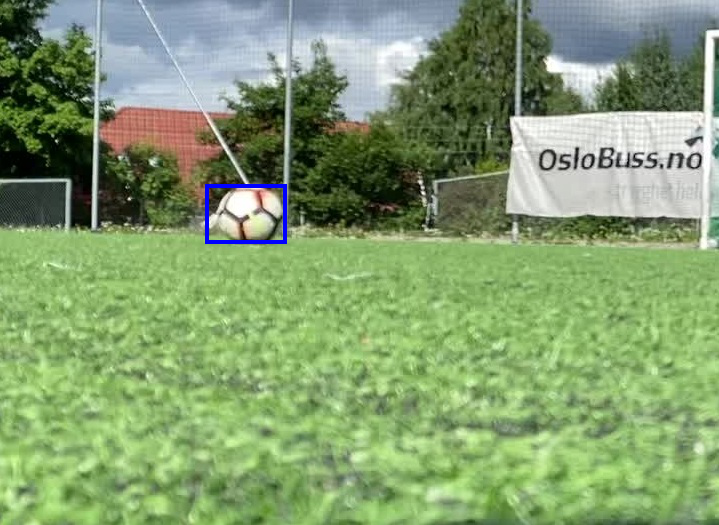

In [126]:
img